In [46]:
# (1)
# finalize this document

# (1b)
# check with these clusters how the inventory trend looks

# (2)
# everytime i fit model, different performance! ??? should i do something, like run many and keep the best?
# ? shall i keep versions and with and without isomap? and use performance metric to compare them?
# do ensemble to the gaussian model that I will choose?

# (3)
# look for the prophet- time series

# (4)
# supervised ML for the rest of orders without customer ID

# (5)
# how to make a pipeline of all these steps??
# and ptactically, to be able to run, when there are new data
# and visually to explain in presentetion

# note:
# i need to see how to handle the fact that some clusters will have different amount of samples,
# the retail has wayyy more clients
# should i do some techniques to make the amounts more equal? 

# Importing libraries and cleaned dataset

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics import pairwise_distances, davies_bouldin_score
from sklearn.manifold import Isomap

import functions
from functions import feat_eng, scaling_data, k_means_model, dbscan_model, scatter_plot, hdbscan_model, gm_model, mshift_model


import hdbscan

In [4]:
# Disabling a specific type of warning from Jupyter, that I know if mistaken for something else
pd.options.mode.chained_assignment = None 

**Original Dataset**:

Chen,Daqing. (2015). Online Retail. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/352/online+retail

In [5]:
# Importing the cleaned dataset from my first notebook
file_path = '../data/data_cleaned.csv'
df = pd.read_csv(file_path, dtype={'InvoiceNo': 'O','StockCode': 'O','Description': 'O',
                                   'Quantity': 'int64','UnitPrice': 'float64',
                                   'CustomerID': 'Int64','Country': 'O'}, parse_dates=['InvoiceDate'])

# Filtering the dataset

Based on the initial analysis conducted in previous notebooks, I have made some preliminary decisions regarding data filtering. These decisions include retaining only sales data from the UK and filtering the dataset to include only sales related to products.

In [6]:
# Filtering out the data that are not for products (shipping, bank fees etc)
df_fltrd = df[df.StockCode != 'OTHER']

# Focusing only on clients from UK (they consist 90% of the clients)
# -> At a later stage I could also check adding Germany and France, to refer then to almost 95% of clients
df_fltrd = df_fltrd[df_fltrd.Country == 'United Kingdom']

# Finally, dropping the null values from CustomerID, since the ML model will be based on the different clients
df_fltrd.dropna(subset='CustomerID', inplace=True)

# Creating new column with the total price for each item 
df_fltrd['TotalPrice'] = df_fltrd.Quantity * df_fltrd.UnitPrice

# Feature Engineering

**Total Quantity:** Wholesale customers are likely to purchase larger quantities of items compared to retail customers: using the total quantity purchased by each customer as a feature.

**Total Price:** Wholesale customers typically spend more money on their purchases compared to retail customers: using the total price of orders can help distinguish between the two groups.

**Average Quantity per Item:** Average quantity per item for each customer. Wholesale customers may buy multiples of the same item in a single order, leading to a higher average quantity per item.

**Average Order Value:** The average amount spent per order by each customer. 

**Total Orders:** Wholesale customers are likely to place more orders than retail customers. To calculate the total number of orders for each customer over a given time period. *Not sure if I will use that for the final model.*

For my ML model I will try clustering algorithms such as K-means, DBSCAN, HDBSCAN, or hierarchical clustering. I will do feature engineering, and conduct an EDA to see my data, and experiment and decide on the best model.

In [7]:
# Function defined at the functions.py
cust = feat_eng(df_fltrd)
cust.head()

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,TotalOrders
CustomerID,,,,,
12346,74215,92768.75,74215.00,92768.75,1
12747,1275,4722.51,12.38,429.32,11
12748,25051,46021.25,5.87,223.40,206
12749,1470,4043.94,7.42,808.79,5
12820,722,938.94,12.24,234.74,4


# EDA

Based on the following analyis I see that I have many outliers and noise in my data. These are the conclusions drawn from this 'EDA' section:

There is an important decision to be made. I see that I have two types of outliers/ noise.
- One comes from the two invoices with number '581483','541431' (two outliers). The Quantity and value of these invoices is huge, not comparable at all with the rest of the 19962 invoices. Also, these 2 invoices, one is from a client that ordered only once (that very big order of only one item) and the other client had this huge order and only two more items at another time. That makes me think that they are not really repeated wholesale customers, and are stand-alone cases that since they differ so much for the model accuracy can be disadvantage.
- Then when I see my data without these two, I can see the noise around my data. This second type of outliers they still need to be treated, but their scale is more comparable to the rest of the data.

I am going to do outlier clipping for the noise at my data, but when I do it without removing the 2 outliers first, the dataset is still very noisy and I don't trust that the trained ML model can be accurate enough.
For that reason I decided in the next section of the notebook 'Outliers' to treat these two types differently.

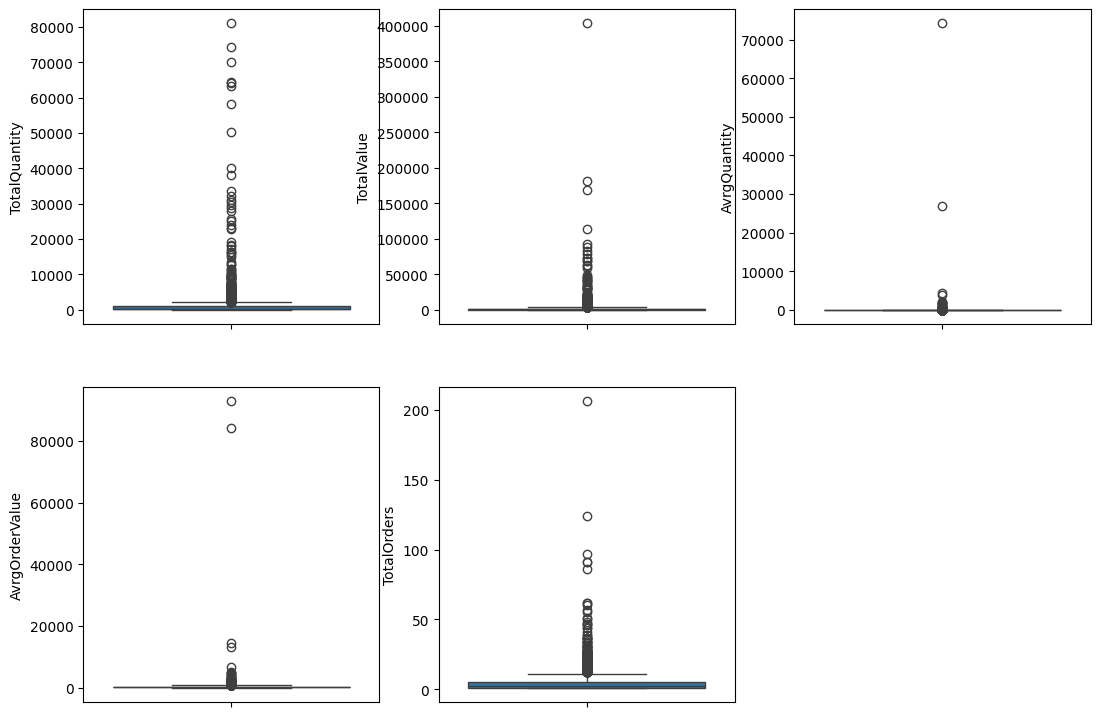

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(13, 9))

sns.boxplot(data=cust['TotalQuantity'], ax=ax[0, 0]) 
sns.boxplot(data=cust['TotalValue'], ax=ax[0, 1]) 
sns.boxplot(data=cust['AvrgQuantity'], ax=ax[0, 2]) 
sns.boxplot(data=cust['AvrgOrderValue'], ax=ax[1, 0]) 
sns.boxplot(data=cust['TotalOrders'], ax=ax[1, 1]) 

# Remove the empty subplot
fig.delaxes(ax[1, 2])

plt.show()

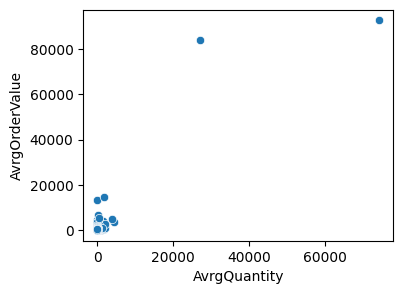

In [9]:
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust, x='AvrgQuantity', y='AvrgOrderValue')
plt.show()

In [10]:
# Looking into the two big outliers
df[df.InvoiceNo.isin(['581483','541431'])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
59649,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.25,12346,United Kingdom
523406,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


In [11]:
df[df.CustomerID.isin([12346,16446])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
59649,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.25,12346,United Kingdom
188029,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446,United Kingdom
188030,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446,United Kingdom
523406,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


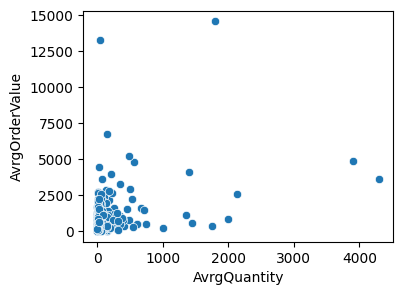

In [12]:
# Checking the scatterplots without the two big outliers, to see my data a bit more clearly
# I am doing he same process as above, using the function I defined
cust_fltrd = feat_eng(df_fltrd[~df_fltrd.InvoiceNo.isin(['581483','541431'])])

# Plotting
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust_fltrd, x='AvrgQuantity', y='AvrgOrderValue')
plt.show()

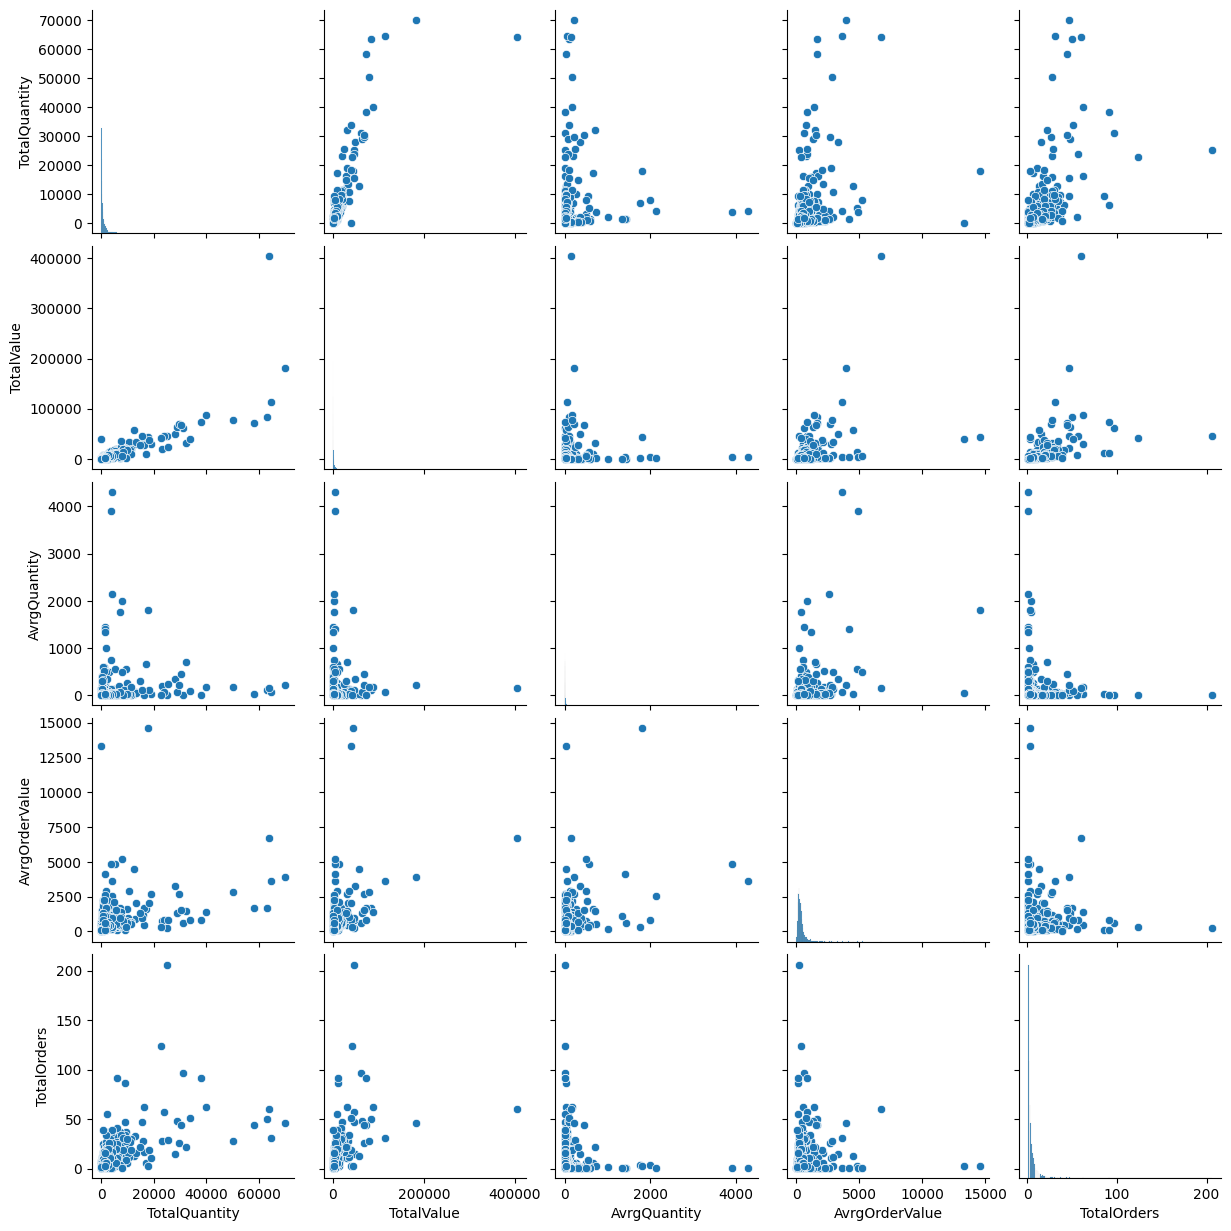

In [13]:
sns.pairplot(cust_fltrd)

# Outliers: data normalization

Based on the noise and outliers that I identified in the previous section, I am going to implement two different approaches for the two types of outliers.
- to the two outliers with the huge difference in scale, I am going to do scaling to a range, scaling them to highest next value (after these two).
- then after completing that, I will do outlier clipping for the rest of the outliers/ noice. I trust that in this way my model will have better scale and will have more accuracy, and at the same time, since I only want two clusters (wholesale and retail) these outliers/noise will still be the highest values in my dataset, and they will most probably be incorporated into the cluster of the wholesale customers. For that I will use the Stardard Deciation method, by z-score to +-3σ (σ is the standard deviation).

Helpful aricle:
https://developers.google.com/machine-learning/data-prep/transform/normalization#:~:text=Z%2Dscore%20is%20a%20variation,extreme%20that%20you%20need%20clipping.

In [14]:
# scaling within a range, updating the Quantity and accordingly the TotalPrice
df_fltrd.loc[df_fltrd.InvoiceNo.isin(['581483','541431']),'Quantity'] = df_fltrd.Quantity.sort_values(ascending=False).values[2]
df_fltrd.loc[df_fltrd.InvoiceNo.isin(['581483','541431']),'TotalPrice'] = df_fltrd.Quantity * df_fltrd.UnitPrice

In [15]:
# Creating the updated customer dataframe
cust_norm = feat_eng(df_fltrd)

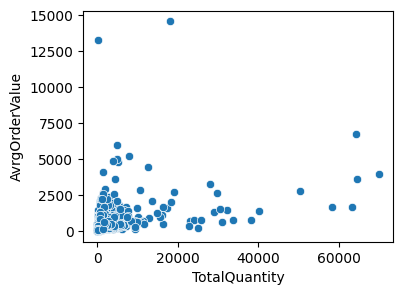

In [16]:
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust_norm, x='TotalQuantity', y='AvrgOrderValue')
plt.show()

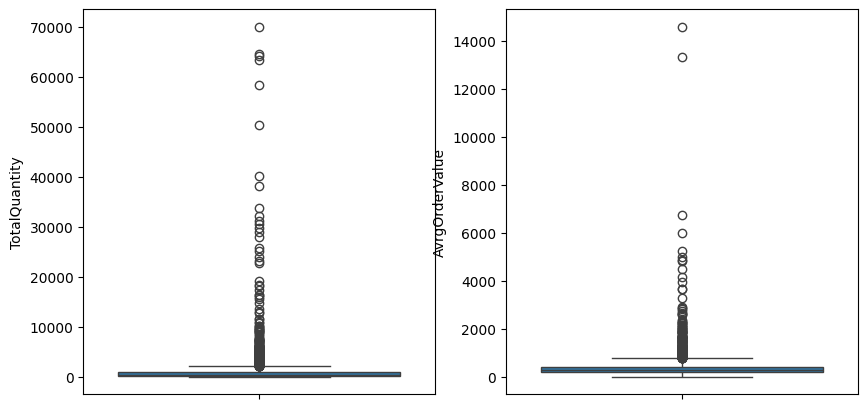

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.boxplot(data=cust_norm['TotalQuantity'], ax=ax[0]) 
sns.boxplot(data=cust_norm['AvrgOrderValue'], ax=ax[1]) 

plt.show()

In [18]:
cust_norm.columns

Index(['TotalQuantity', 'TotalValue', 'AvrgQuantity', 'AvrgOrderValue',
       'TotalOrders'],
      dtype='object')

In [19]:
cust_norm_clip = cust_norm.copy()

In [20]:
# I will find the Upper limit with the standard deviation method
# I don't have lower limit, cause everything start from 0
tq_UpperLimit = (cust_norm_clip['TotalQuantity'].mean() + cust_norm_clip['TotalQuantity'].std()*3).round(0).astype(int)
tv_UpperLimit = (cust_norm_clip['TotalValue'].mean() + cust_norm_clip['TotalValue'].std()*3).round(2)
av_UpperLimit = (cust_norm_clip['AvrgQuantity'].mean() + cust_norm_clip['AvrgQuantity'].std()*3).round(2)
aov_UpperLimit = (cust_norm_clip['AvrgOrderValue'].mean() + cust_norm_clip['AvrgOrderValue'].std()*3).round(2)
to_UpperLimit = (cust_norm_clip['TotalOrders'].mean() + cust_norm_clip['TotalOrders'].std()*3).round(0).astype(int)

In [21]:
# Checking how many outliers there are that fit these requirements
cust_norm_clip[cust_norm_clip['TotalQuantity'] > tq_UpperLimit].shape[0] # 34 instances
cust_norm_clip[cust_norm_clip['TotalValue'] > tv_UpperLimit].shape[0] # 32 instances
cust_norm_clip[cust_norm_clip['AvrgQuantity'] > av_UpperLimit].shape[0] # 23 instances
cust_norm_clip[cust_norm_clip['AvrgOrderValue'] > aov_UpperLimit].shape[0] # 44 instances
cust_norm_clip[cust_norm_clip['TotalOrders'] > to_UpperLimit].shape[0] # 50 instances, more outliers

50

In [22]:
# from domain knowledge I was debating if to do total orders. Given also the outliers, I will not use it
cust_norm_clip.drop('TotalOrders',axis=1,inplace=True)

In [23]:
# Clipping the data
cust_norm_clip.loc[cust_norm_clip['TotalQuantity'] > tq_UpperLimit , 'TotalQuantity'] = tq_UpperLimit
cust_norm_clip.loc[cust_norm_clip['TotalValue'] > tv_UpperLimit , 'TotalValue'] = tv_UpperLimit
cust_norm_clip.loc[cust_norm_clip['AvrgQuantity'] > av_UpperLimit , 'AvrgQuantity'] = av_UpperLimit
cust_norm_clip.loc[cust_norm_clip['AvrgOrderValue'] > aov_UpperLimit , 'AvrgOrderValue'] = aov_UpperLimit

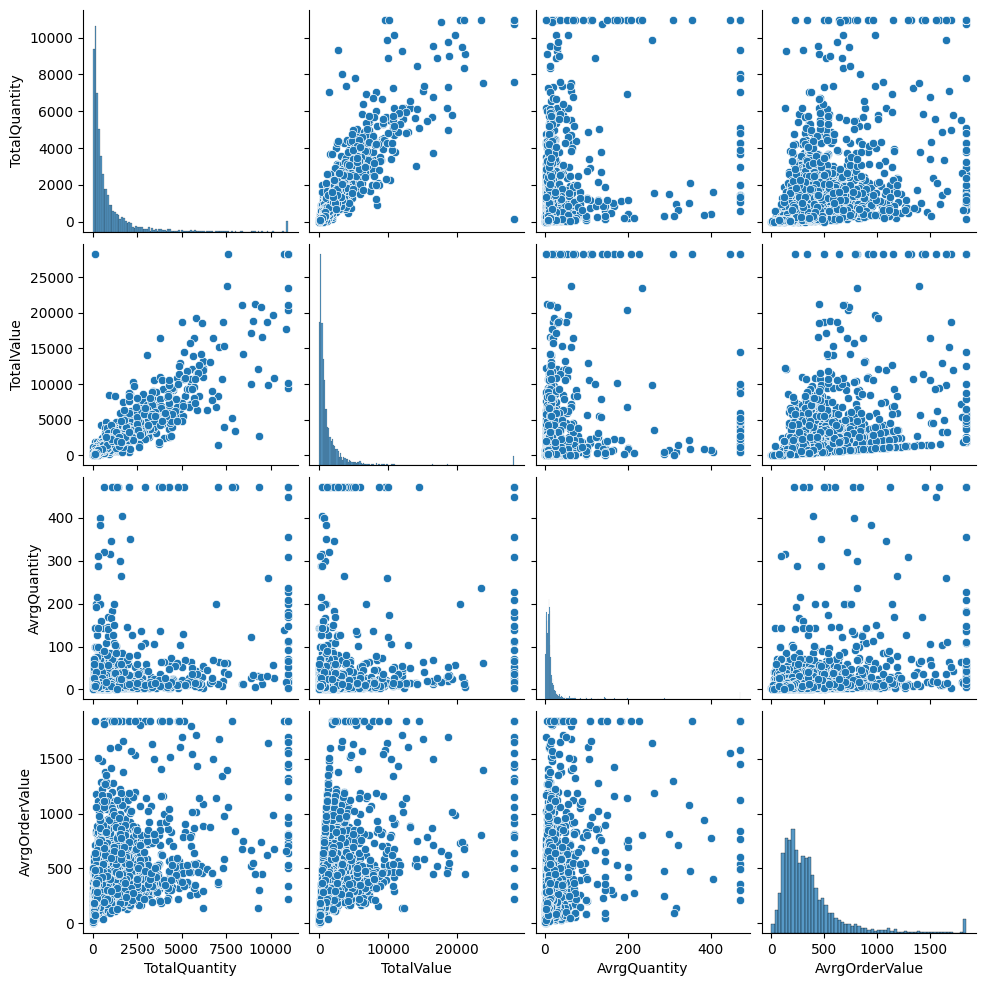

In [24]:
# looking much better
sns.pairplot(cust_norm_clip)

# Scaling data

Normalization rescales the data to have values between 0 and 1, while standardization rescales the data to have a mean of 0 and a standard deviation of 1. There are various methods to normalize or standardize the data, such as min-max scaling, z-score scaling, or log transformation. Here I tried the first two, but I will choose the standardization (z-score scaling) that is less sensitive to outliers than min-max scaling (where scale is heavily influenced by the extreme maximum and minimum values).

### StandardScaler

Standarization: the values are transfomed to end up with mean = 0 and std = 0.

$$z = \frac{(x-mean(x))}{\sigma}$$

In [25]:
# Scaling the data, function defined at functions.py
cust_norm_clip_stndrd = scaling_data(cust_norm_clip)

# Dimensionality reduction

Non-linear dimensionality reduction through Isometric Mapping.

In [26]:
# Create an Isomap object with the desired number of components
isomap = Isomap(n_neighbors=5, n_components=2)

# Fit the Isomap model to the data and transform it to the lower-dimensional space
cust_norm_clip_stndrd_reduced = isomap.fit_transform(cust_norm_clip_stndrd)

In [27]:
cust_norm_clip_stndrd_reduced = pd.DataFrame(cust_norm_clip_stndrd_reduced, columns = ['Component 1', 'Component 2'], 
                                             index=cust_norm_clip_stndrd.index)
cust_norm_clip_stndrd_reduced.head()

,Component 1,Component 2
CustomerID,,
12346,12.442217,16.067094
12747,1.307553,-0.701091
12748,15.738592,-2.993549
12749,1.333805,-0.103321
12820,-0.297232,-0.082926


# Elbow Method, for the optimal number of clusters

I am doing the Elbow Method (most commonly used with clustering algorithms like K-means) to see how the inertia looks depending on the number of clusters.

From the result I can see that doing 4 cluster would be a good option.

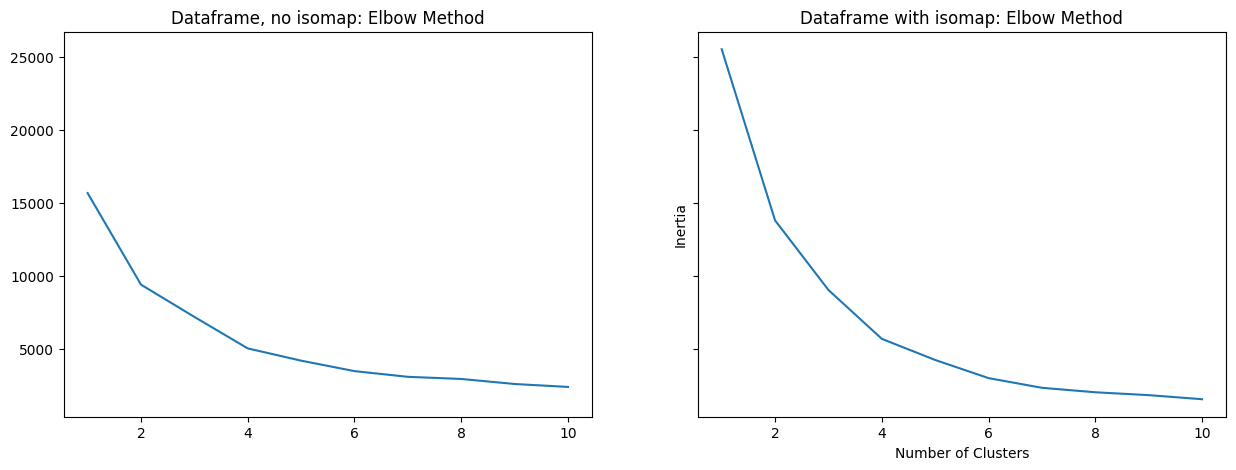

In [28]:
# Finding the optimal number of clusters, looking at my data with reduced dimensionality and without
list_df = [cust_norm_clip_stndrd, cust_norm_clip_stndrd_reduced]
list_df_names = ['Dataframe, no isomap', 'Dataframe with isomap']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

# Checking the plot for 1-10 clusters
for i, (model, model_name) in enumerate(zip(list_df,list_df_names)):
    inertias = []
    for j in range(1,11):
        kmeans = KMeans(n_clusters=j)
        kmeans.fit(model)
        inertias.append(kmeans.inertia_)
    ax[i].plot(range(1,11), inertias)
    ax[i].set_title(f'{model_name}: Elbow Method')
    

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# 4 clusters seems the best for both models

# Building models

Helpful resource:
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

## Clustering with K-Means

After looking at my EDA, I conclude that K-Means will not be a good model for my dataset. I will test it however anywyay.

K-means can be quite sensitive to oultiers and has an intrinsic preference for globular clusters.

Kmeans silhouette coefficient:  0.6066
Kmeans Calinski-Harabasz Index:  2964.4757
Kmeans Davies-Bouldin Index:  0.8324
Label: 3, Percentage total customers: 17.77%
Label: 0, Percentage total customers: 79.53%
Label: 2, Percentage total customers: 1.79%
Label: 1, Percentage total customers: 0.92%


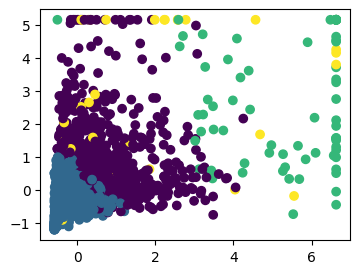

In [29]:
# Choosing 4 clusters, using function defined in the functions.py
cust_kmeans = k_means_model(cust_norm_clip_stndrd,4)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_kmeans['TotalQuantity'], y=cust_kmeans['AvrgOrderValue'], c=cust_kmeans['kmeans_labels'])
plt.show()

### Clustering with K-means - Less features

Kmeans silhouette coefficient:  0.6822
Kmeans Calinski-Harabasz Index:  3696.0375
Kmeans Davies-Bouldin Index:  0.7556
Label: 1, Percentage total customers: 76.69%
Label: 0, Percentage total customers: 0.97%
Label: 3, Percentage total customers: 20.07%
Label: 2, Percentage total customers: 2.27%


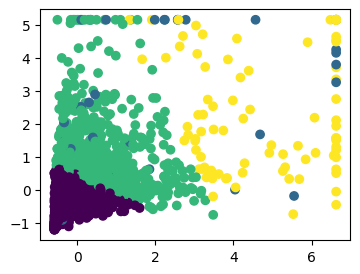

In [30]:
# 4 clusters, 3 features, using function defined in the functions.py
cust_kmeans2= k_means_model(cust_norm_clip_stndrd[['TotalQuantity','AvrgQuantity','AvrgOrderValue']],4)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_kmeans2['TotalQuantity'], y=cust_kmeans2['AvrgOrderValue'], c=cust_kmeans2['kmeans_labels'])
plt.show()

### Clustering with K-means - dimensionality reduction

Kmeans silhouette coefficient:  0.6997
Kmeans Calinski-Harabasz Index:  4672.2994
Kmeans Davies-Bouldin Index:  0.5867
Label: 3, Percentage total customers: 11.41%
Label: 0, Percentage total customers: 86.55%
Label: 2, Percentage total customers: 1.33%
Label: 1, Percentage total customers: 0.71%


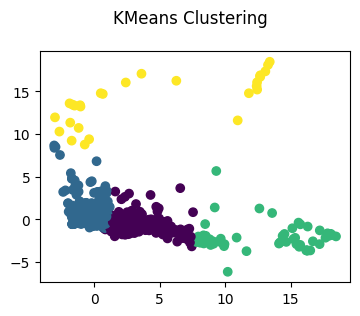

In [31]:
# using the dataframe with the isomap applied
# 4 clusters, using function defined in the functions.py
cust_kmeans3= k_means_model(cust_norm_clip_stndrd_reduced,4)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_kmeans3['Component 1'], y=cust_kmeans3['Component 2'], c=cust_kmeans3['kmeans_labels'])
plt.suptitle("KMeans Clustering", y=1.02)
plt.savefig("../images/kmeans.png", bbox_inches='tight')
plt.show()

## Clustering with DBSCAN

A density-based clustering algorithm. DBSCAN tends to fall short of identifying clusters with non-uniform density.

DBSCAN silhouette coefficient:  0.7438
DBSCAN Calinski-Harabasz Index:  2138.0466
DBSCAN Davies-Bouldin Index:  1.1391
Label: -1, Percentage total customers: 7.56%
Label: 0, Percentage total customers: 92.44%


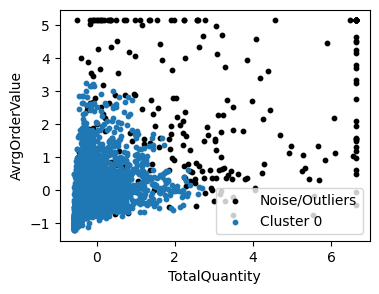

In [32]:
# Training DBSCAN model, eps=0.5, min_samples=10, using function defined in the functions.py
cust_dbscan = dbscan_model(cust_norm_clip_stndrd, 0.5, 10)

scatter_plot(cust_dbscan[['TotalQuantity','AvrgOrderValue']], cust_dbscan['dbscan_labels'])

## Clustering with DBSCAN - with less features

At the conclusion is shown that less features for this model **does not** work better.

DBSCAN silhouette coefficient:  0.7658
DBSCAN Calinski-Harabasz Index:  2192.8079
DBSCAN Davies-Bouldin Index:  1.0895
Label: -1, Percentage total customers: 5.77%
Label: 0, Percentage total customers: 94.23%


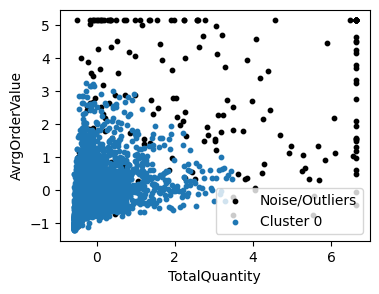

In [33]:
# Training DBSCAN model, eps=0.5, min_samples=10, using function defined in the functions.py
cust_dbscan2 = dbscan_model(cust_norm_clip_stndrd[['TotalQuantity','AvrgQuantity','AvrgOrderValue']], 0.5, 10)

scatter_plot(cust_dbscan2[['TotalQuantity','AvrgOrderValue']], cust_dbscan2['dbscan_labels'])

## Clustering with DBSCAN - dimensionality reduction

DBSCAN silhouette coefficient:  0.8442
DBSCAN Calinski-Harabasz Index:  1786.2705
DBSCAN Davies-Bouldin Index:  1.2317
Label: -1, Percentage total customers: 3.68%
Label: 0, Percentage total customers: 96.32%


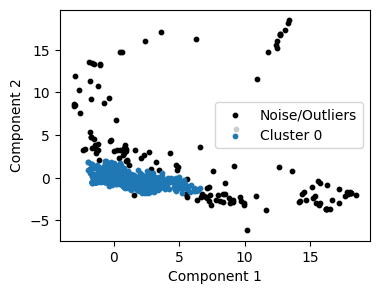

In [34]:
# Training DBSCAN model with the isomap applied, eps=0.5, min_samples=10, using function defined in the functions.py
cust_dbscan3 = dbscan_model(cust_norm_clip_stndrd_reduced, 0.5, 10)

scatter_plot(cust_dbscan3[['Component 1','Component 2']], cust_dbscan3['dbscan_labels'],'Component 1','Component 2')

## Clustering with HDBSCAN

HDBSCAN silhouette coefficient:  0.7272
HDBSCAN Calinski-Harabasz Index:  1046.6115
HDBSCAN Davies-Bouldin Index:  0.9566
Label: -1, Percentage total customers: 4.52%
Label: 1, Percentage total customers: 94.84%
Label: 0, Percentage total customers: 0.28%
Label: 2, Percentage total customers: 0.36%


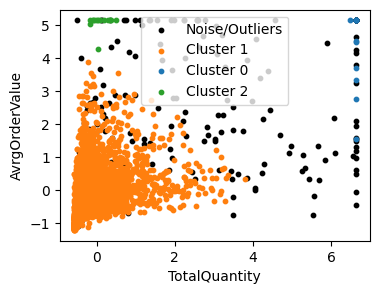

In [35]:
# Training HDBSCAN model, min_cluster_size=10, using function defined in the functions.py
cust_hdbscan = hdbscan_model(cust_norm_clip_stndrd, 10)

scatter_plot(cust_hdbscan[['TotalQuantity','AvrgOrderValue']], cust_hdbscan['hdbscan_labels'])

## Clustering with HDBSCAN - dimensionality reduction

HDBSCAN silhouette coefficient:  0.8704
HDBSCAN Calinski-Harabasz Index:  1592.1876
HDBSCAN Davies-Bouldin Index:  1.1154
Label: 0, Percentage total customers: 0.28%
Label: 3, Percentage total customers: 98.24%
Label: 2, Percentage total customers: 0.77%
Label: -1, Percentage total customers: 0.46%
Label: 1, Percentage total customers: 0.26%


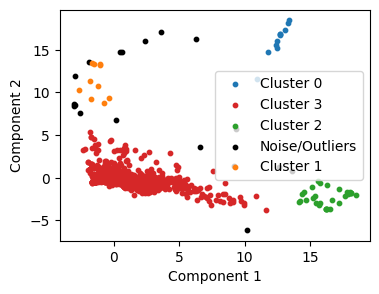

In [36]:
# Training HDBSCAN model with isomap applied, min_cluster_size=10, using function defined in the functions.py
cust_hdbscan2 = hdbscan_model(cust_norm_clip_stndrd_reduced, 10)

scatter_plot(cust_hdbscan2[['Component 1','Component 2']], cust_hdbscan2['hdbscan_labels'],'Component 1','Component 2')

## Gaussian Mixture clustering

GaussianMixture silhouette coefficient:  0.4414
GaussianMixture Calinski-Harabasz Index:  1562.6145
GaussianMixture Davies-Bouldin Index:  1.2124
Label: 2, Percentage total customers: 50.52%
Label: 3, Percentage total customers: 38.5%
Label: 1, Percentage total customers: 4.03%
Label: 0, Percentage total customers: 6.94%


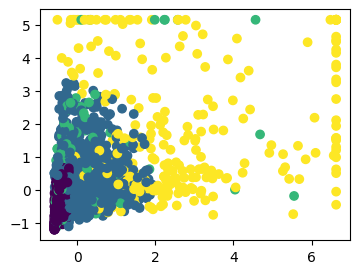

In [37]:
# Choosing 4 clusters, using function defined in the functions.py
cust_gm = gm_model(cust_norm_clip_stndrd, 4)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_gm['TotalQuantity'], y=cust_gm['AvrgOrderValue'], c=cust_gm['gm_labels'])
plt.show()

## Gaussian Mixture clustering - Less features

GaussianMixture silhouette coefficient:  0.5688
GaussianMixture Calinski-Harabasz Index:  2322.0461
GaussianMixture Davies-Bouldin Index:  1.3450
Label: 1, Percentage total customers: 42.84%
Label: 3, Percentage total customers: 5.95%
Label: 2, Percentage total customers: 18.25%
Label: 0, Percentage total customers: 32.96%


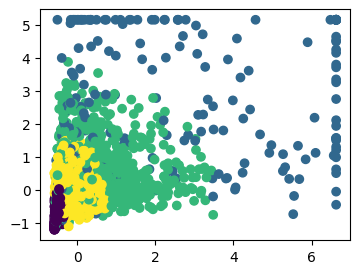

In [38]:
# Choosing 4 clusters, dataframe with 3 features, using function defined in the functions.py
cust_gm2 = gm_model(cust_norm_clip_stndrd[['TotalQuantity','AvrgQuantity','AvrgOrderValue']], 4)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_gm2['TotalQuantity'], y=cust_gm2['AvrgOrderValue'], c=cust_gm2['gm_labels'])
plt.show()

## Gaussian Mixture clustering - dimensionality reduction + 2 clusters

GaussianMixture silhouette coefficient:  0.7077
GaussianMixture Calinski-Harabasz Index:  1485.3141
GaussianMixture Davies-Bouldin Index:  1.1887
Label: 1, Percentage total customers: 87.18%
Label: 0, Percentage total customers: 12.82%


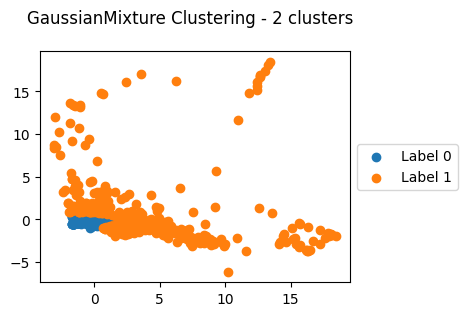

In [39]:
# Choosing 4 clusters, dataframe with isomap applied, using function defined in the functions.py
cust_gm5 = gm_model(cust_norm_clip_stndrd_reduced, 2)

# Plotting the results
label_names = {0: 'Label 0', 1: 'Label 1'}

# Plotting the results
plt.figure(figsize=(4, 3))
for label, name in label_names.items():
    plt.scatter(x=cust_gm5[cust_gm5['gm_labels'] == label]['Component 1'], 
                y=cust_gm5[cust_gm5['gm_labels'] == label]['Component 2'], 
                label=name)
plt.suptitle("GaussianMixture Clustering - 2 clusters", y=1.02)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.savefig("../images/gm-2.png", bbox_inches='tight')
plt.show()

## Gaussian Mixture clustering - dimensionality reduction + 4 clusters

GaussianMixture silhouette coefficient:  0.7270
GaussianMixture Calinski-Harabasz Index:  2444.3242
GaussianMixture Davies-Bouldin Index:  0.9539
Label: 2, Percentage total customers: 57.24%
Label: 3, Percentage total customers: 7.0%
Label: 1, Percentage total customers: 0.89%
Label: 0, Percentage total customers: 34.87%


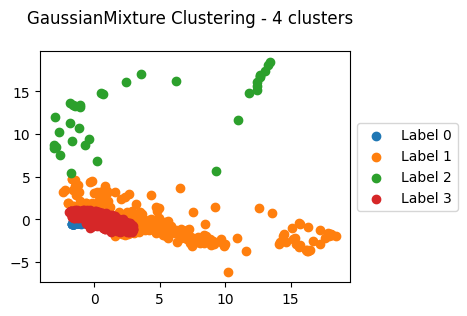

In [40]:
# Choosing 4 clusters, dataframe with isomap applied, using function defined in the functions.py
cust_gm3 = gm_model(cust_norm_clip_stndrd_reduced, 4)

# Plotting the results
label_names = {0: 'Label 0', 1: 'Label 1', 2: 'Label 2', 3: 'Label 3'}

# Plotting the results
plt.figure(figsize=(4, 3))
for label, name in label_names.items():
    plt.scatter(x=cust_gm3[cust_gm3['gm_labels'] == label]['Component 1'], 
                y=cust_gm3[cust_gm3['gm_labels'] == label]['Component 2'], 
                label=name)
plt.suptitle("GaussianMixture Clustering - 4 clusters", y=1.02)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.savefig("../images/gm-4.png", bbox_inches='tight')
plt.show()

## Gaussian Mixture clustering - dimensionality reduction + 6 clusters

GaussianMixture silhouette coefficient:  0.7694
GaussianMixture Calinski-Harabasz Index:  3914.8937
GaussianMixture Davies-Bouldin Index:  0.8592
Label: 2, Percentage total customers: 51.11%
Label: 4, Percentage total customers: 9.47%
Label: 3, Percentage total customers: 0.56%
Label: 0, Percentage total customers: 0.77%
Label: 1, Percentage total customers: 36.61%
Label: 5, Percentage total customers: 1.48%


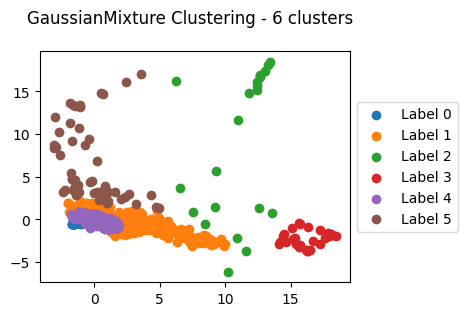

In [41]:
# Choosing 6 clusters, dataframe with isomap applied, using function defined in the functions.py
cust_gm4 = gm_model(cust_norm_clip_stndrd_reduced, 6)

# Plotting the results
label_names = {0: 'Label 0', 1: 'Label 1', 2: 'Label 2', 3: 'Label 3', 4: 'Label 4', 5: 'Label 5'}

# Plotting the results
plt.figure(figsize=(4, 3))
for label, name in label_names.items():
    plt.scatter(x=cust_gm4[cust_gm4['gm_labels'] == label]['Component 1'], 
                y=cust_gm4[cust_gm4['gm_labels'] == label]['Component 2'], 
                label=name)
plt.suptitle("GaussianMixture Clustering - 6 clusters", y=1.02)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.savefig("../images/gm-6.png", bbox_inches='tight')
plt.show()

## Mean shift clustering

MeanShift silhouette coefficient:  0.8445
MeanShift Calinski-Harabasz Index:  1399.2164
MeanShift Davies-Bouldin Index:  0.6837
Label: 1, Percentage total customers: 98.75%
Label: 0, Percentage total customers: 1.25%


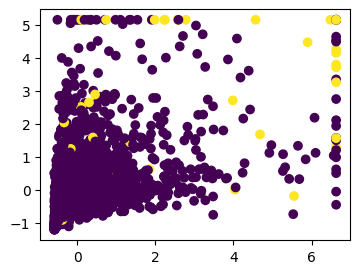

In [42]:
# Function, with bandwidth=5 for the clustering defined in the functions.py
cust_mshift = mshift_model(cust_norm_clip_stndrd,5)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_mshift['TotalQuantity'], y=cust_mshift['AvrgOrderValue'], c=cust_mshift['mshift_labels'])
plt.show()

## Mean shift clustering - dimensionality reduction

MeanShift silhouette coefficient:  0.8657
MeanShift Calinski-Harabasz Index:  2866.5570
MeanShift Davies-Bouldin Index:  0.3970
Label: 3, Percentage total customers: 97.73%
Label: 0, Percentage total customers: 1.33%
Label: 1, Percentage total customers: 0.61%
Label: 2, Percentage total customers: 0.33%


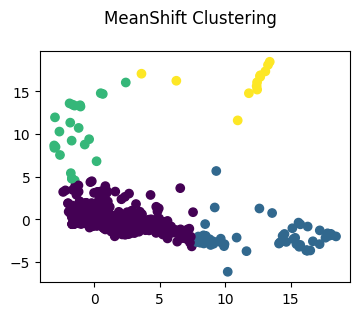

In [43]:
# Function, with bandwidth=5 and isomap applied for the clustering defined in the functions.py
cust_mshift2 = mshift_model(cust_norm_clip_stndrd_reduced,5)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_mshift2['Component 1'], y=cust_mshift2['Component 2'], c=cust_mshift2['mshift_labels'])
plt.suptitle("MeanShift Clustering", y=1.02)
plt.savefig("../images/mshift.png", bbox_inches='tight')
plt.show()

# Model evaluation

Visual inspection has also been done, comparing the pairplots for the models.
I am gonna do 3 metrics: a higher Calinski-Harabasz Index suggests better cluster separation, while a lower Davies-Bouldin Index indicates better cluster quality, and a higher Silhouette Score suggests denser, well-separated clusters.

Helpful resource: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

## Silhouette Coefficient

A higher Silhouette Coefficient score relates to a model with better defined clusters
- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
- The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

In [54]:
print(f"Kmeans silhouette coefficient: {metrics.silhouette_score(cust_kmeans, cust_kmeans['kmeans_4'], metric='euclidean')}")
print(f"Kmeans-LessFeatures silhouette coefficient: {metrics.silhouette_score(cust_kmeans2, cust_kmeans2['kmeans_4'], metric='euclidean')}")
print("")
print(f"DBSCAN silhouette coefficient: {metrics.silhouette_score(cust_dbscan, cust_dbscan['dbscan_labels'], metric='euclidean')}")
print(f"DBSCAN-LessFeatures silhouette coefficient: {metrics.silhouette_score(cust_dbscan2, cust_dbscan2['dbscan_labels'], metric='euclidean')}")
print("")
print(f"HDBSCAN silhouette coefficient: {metrics.silhouette_score(cust_hdbscan, cust_hdbscan['hdbscan_labels'], metric='euclidean')}")
print("")
print(f"GaussianMixture silhouette coefficient: {metrics.silhouette_score(cust_gm, cust_gm['gm_4'], metric='euclidean')}")
print(f"GaussianMixture-LessFeatures silhouette coefficient: {metrics.silhouette_score(cust_gm2, cust_gm2['gm_4'], metric='euclidean')}")
print("")
print(f"MeanShift silhouette coefficient: {metrics.silhouette_score(cust_mshift, cust_mshift['mshift'], metric='euclidean')}")
print(f"MeanShift-LessFeatures silhouette coefficient: {metrics.silhouette_score(cust_mshift2, cust_mshift2['mshift'], metric='euclidean')}")

Kmeans silhouette coefficient: 0.6787005978104956
Kmeans-LessFeatures silhouette coefficient: 0.7456877730653068

DBSCAN silhouette coefficient: 0.7437620394715588
DBSCAN-LessFeatures silhouette coefficient: 0.6026343144934078

HDBSCAN silhouette coefficient: 0.7312014139029822

GaussianMixture silhouette coefficient: 0.584461942678694
GaussianMixture-LessFeatures silhouette coefficient: 0.5152601980071299

MeanShift silhouette coefficient: 0.6959797122085571
MeanShift-LessFeatures silhouette coefficient: 0.7142956982129238


## Calinski-Harabasz Index

A higher Calinski-Harabasz score relates to a model with better defined clusters.
- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
- The score is fast to compute.
- The Calinski-Harabasz index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

In [55]:
print(f"Kmeans Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_kmeans, cust_kmeans['kmeans_4'])}")
print(f"Kmeans-LessFeatures Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_kmeans2, cust_kmeans2['kmeans_4'])}")
print("")
print(f"DBSCAN Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_dbscan, cust_dbscan['dbscan_labels'])}")
print(f"DBSCAN-LessFeatures Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_dbscan2, cust_dbscan2['dbscan_labels'])}")
print("")
print(f"HDBSCAN Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_hdbscan, cust_hdbscan['hdbscan_labels'])}")
print("")
print(f"GaussianMixture Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_gm, cust_gm['gm_4'])}")
print(f"GaussianMixture-LessFeatures Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_gm2, cust_gm2['gm_4'])}")
print("")
print(f"MeanShift Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_mshift, cust_mshift['mshift'])}")
print(f"MeanShift-LessFeatures Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_mshift2, cust_mshift2['mshift'])}")

Kmeans Calinski-Harabasz Index: 3392.783127630024
Kmeans-LessFeatures Calinski-Harabasz Index: 4441.091739118907

DBSCAN Calinski-Harabasz Index: 2138.0466036001717
DBSCAN-LessFeatures Calinski-Harabasz Index: 1773.3523072031228

HDBSCAN Calinski-Harabasz Index: 1256.1367233726573

GaussianMixture Calinski-Harabasz Index: 1764.9796813369687
GaussianMixture-LessFeatures Calinski-Harabasz Index: 1828.3988864624087

MeanShift Calinski-Harabasz Index: 12858.689912262176
MeanShift-LessFeatures Calinski-Harabasz Index: 15411.633220755444


## Davies-Bouldin Index

Lower Davies-Bouldin index relates to a model with better separation between the clusters.
- The computation of Davies-Bouldin is simpler than that of Silhouette scores.
- The index is solely based on quantities and features inherent to the dataset as its computation only uses point-wise distances.
- The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained from DBSCAN.
- The usage of centroid distance limits the distance metric to Euclidean space.

In [56]:
print(f"Kmeans Davies-Bouldin Index: {davies_bouldin_score(cust_kmeans, cust_kmeans['kmeans_4'])}")
print(f"Kmeans-LessFeatures Davies-Bouldin Index: {davies_bouldin_score(cust_kmeans2, cust_kmeans2['kmeans_4'])}")
print("")
print(f"DBSCAN Davies-Bouldin Index: {davies_bouldin_score(cust_dbscan, cust_dbscan['dbscan_labels'])}")
print(f"DBSCAN-LessFeatures Davies-Bouldin Index: {davies_bouldin_score(cust_dbscan2, cust_dbscan2['dbscan_labels'])}")
print("")
print(f"HDBSCAN Davies-Bouldin Index: {davies_bouldin_score(cust_hdbscan, cust_hdbscan['hdbscan_labels'])}")
print("")
print(f"GaussianMixture Davies-Bouldin Index: {davies_bouldin_score(cust_gm, cust_gm['gm_4'])}")
print(f"GaussianMixture-Less Features Davies-Bouldin Index: {davies_bouldin_score(cust_gm2, cust_gm2['gm_4'])}")
print("")
print(f"MeanShift Davies-Bouldin Index: {davies_bouldin_score(cust_mshift, cust_mshift['mshift'])}")
print(f"MeanShift-LessFeatures Davies-Bouldin Index: {davies_bouldin_score(cust_mshift2, cust_mshift2['mshift'])}")

Kmeans Davies-Bouldin Index: 0.7085192869326515
Kmeans-LessFeatures Davies-Bouldin Index: 0.7130701590102658

DBSCAN Davies-Bouldin Index: 1.1390741633945884
DBSCAN-LessFeatures Davies-Bouldin Index: 1.1844138441028582

HDBSCAN Davies-Bouldin Index: 0.9666221475828692

GaussianMixture Davies-Bouldin Index: 1.1430638241271995
GaussianMixture-Less Features Davies-Bouldin Index: 1.266477681018622

MeanShift Davies-Bouldin Index: 0.2824749159057506
MeanShift-LessFeatures Davies-Bouldin Index: 0.2907980475490986


## Count of customers per cluster

In [ ]:
# Gaussian Mixture clustering - dimensionality reduction + 6 clusters

In [90]:
# I want to see for the most successful model, how many clients that clusters have
models = [cust_clust_kmeans, cust_clust_gm, cust_clust_mshift]
model_names = ['KMeans', 'Gaussian Mixture', 'Mean Shift']

for cust, model_name in zip(models, model_names):
    for i in range(4):
        print(f"Model: {model_name}, Label: {i}, Total Customers: {cust[cust.Labels == i].shape[0]}")

Model: KMeans, Label: 0, Total Customers: 3141
Model: KMeans, Label: 1, Total Customers: 66
Model: KMeans, Label: 2, Total Customers: 677
Model: KMeans, Label: 3, Total Customers: 33
Model: Gaussian Mixture, Label: 0, Total Customers: 1286
Model: Gaussian Mixture, Label: 1, Total Customers: 1693
Model: Gaussian Mixture, Label: 2, Total Customers: 231
Model: Gaussian Mixture, Label: 3, Total Customers: 707
Model: Mean Shift, Label: 0, Total Customers: 3482
Model: Mean Shift, Label: 1, Total Customers: 33
Model: Mean Shift, Label: 2, Total Customers: 56
Model: Mean Shift, Label: 3, Total Customers: 25


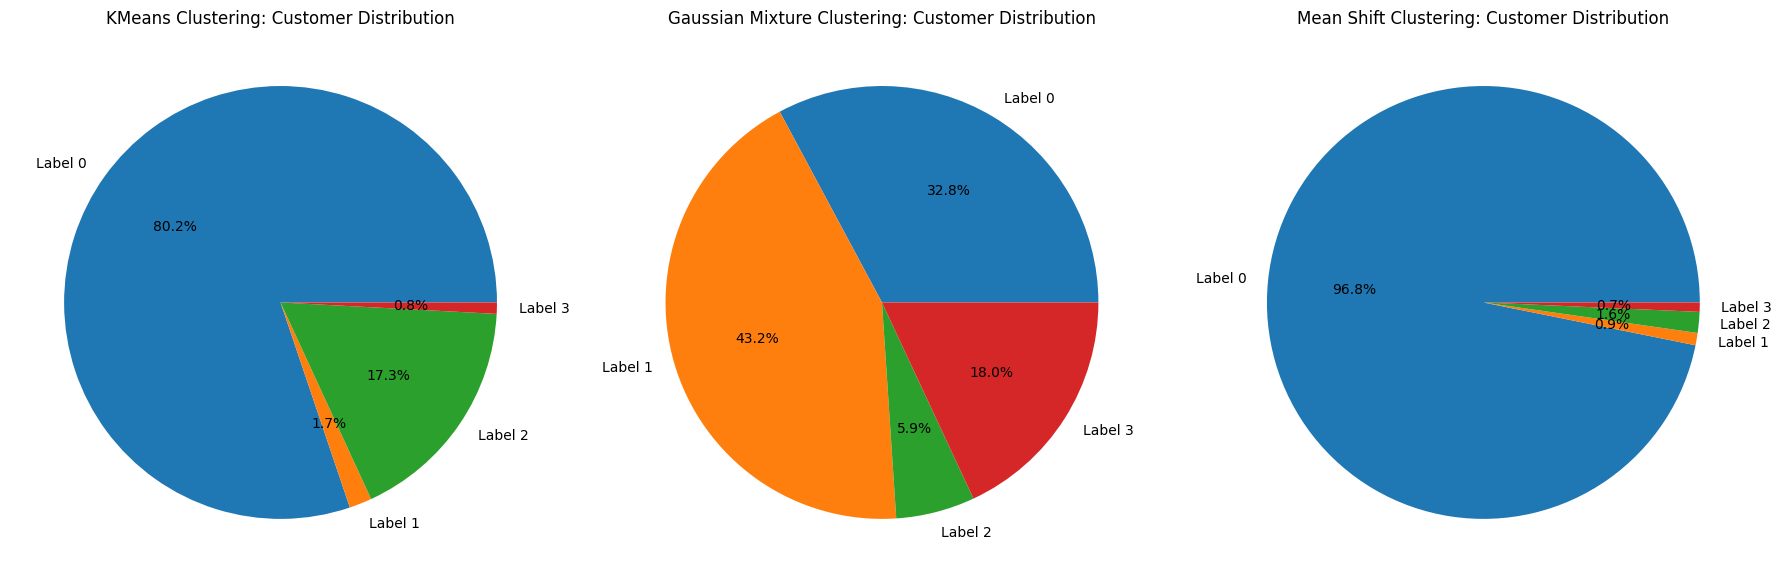

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for i, (cust, model_name) in enumerate(zip(models, model_names)):
    label_percentages = [(count / cust.shape[0]) * 100 for count in [cust[cust.Labels == i].shape[0] for i in range(4)]]
    
    ax[i].pie(label_percentages, labels=[f'Label {i}' for i in range(4)], autopct='%1.1f%%')
    ax[i].set_title(f'{model_name} Clustering: Customer Distribution')

plt.tight_layout()
plt.show()

# Model Comparison conclusions

Firstly, the test scores work the best to compare models of the same type. By looking at these scores, it is evident if the models perform better with more or less features:
- Kmeans: model with **more** features better
- DBSCAN: model with **more** features better
- HDBSCAN (this I didn't check, cause I was not satisfied with the model)
- Gaussian Mixture: model with **less** features better
- Mean Shift: model with **more** features better 

Secondly, I conclude:
- I will opt to not use DBSCAN or HDBSCAN that filter out outliers, cause I actually want to cluster all my data and not exclude some. I could cluster the outleirs on a cluster of their own, but propably it is not the ideal solution for best cluster metrics and characteristic. Also HDBSCAN didn't really work well anyway.
- I need to decide between K-means/ Gaussian Mixture/ Mean Shift.
- Although from visual inspection, the results of Mean Shift did not look good, it has the best scores.

In [48]:

##################
cust_clust_test = pd.merge(df_fltrd, cust_gm3['gm_labels'], left_index=True, right_index=True)
cust_clust_test.rename(columns={'gm_labels':'Labels'}, inplace=True)

# Saving clean dataset
df_fltrd.to_csv('../data/data_test_filtered.csv', index=False)
# Saving clean dataset
cust_clust_test.to_csv('../data/data_test_with_labels.csv', index=False)
##################

In [62]:
cust_clust_kmeans = pd.merge(cust_norm_clip, cust_kmeans['kmeans_4'], left_index=True, right_index=True)
cust_clust_kmeans.rename(columns={'kmeans_4':'Labels'}, inplace=True)

cust_clust_gm = pd.merge(cust_norm_clip, cust_gm2['gm_4'], left_index=True, right_index=True)
cust_clust_gm.rename(columns={'gm_4':'Labels'}, inplace=True)

cust_clust_mshift = pd.merge(cust_norm_clip, cust_mshift['mshift'], left_index=True, right_index=True)
cust_clust_mshift.rename(columns={'mshift':'Labels'}, inplace=True)

### Plots for Kmeans model

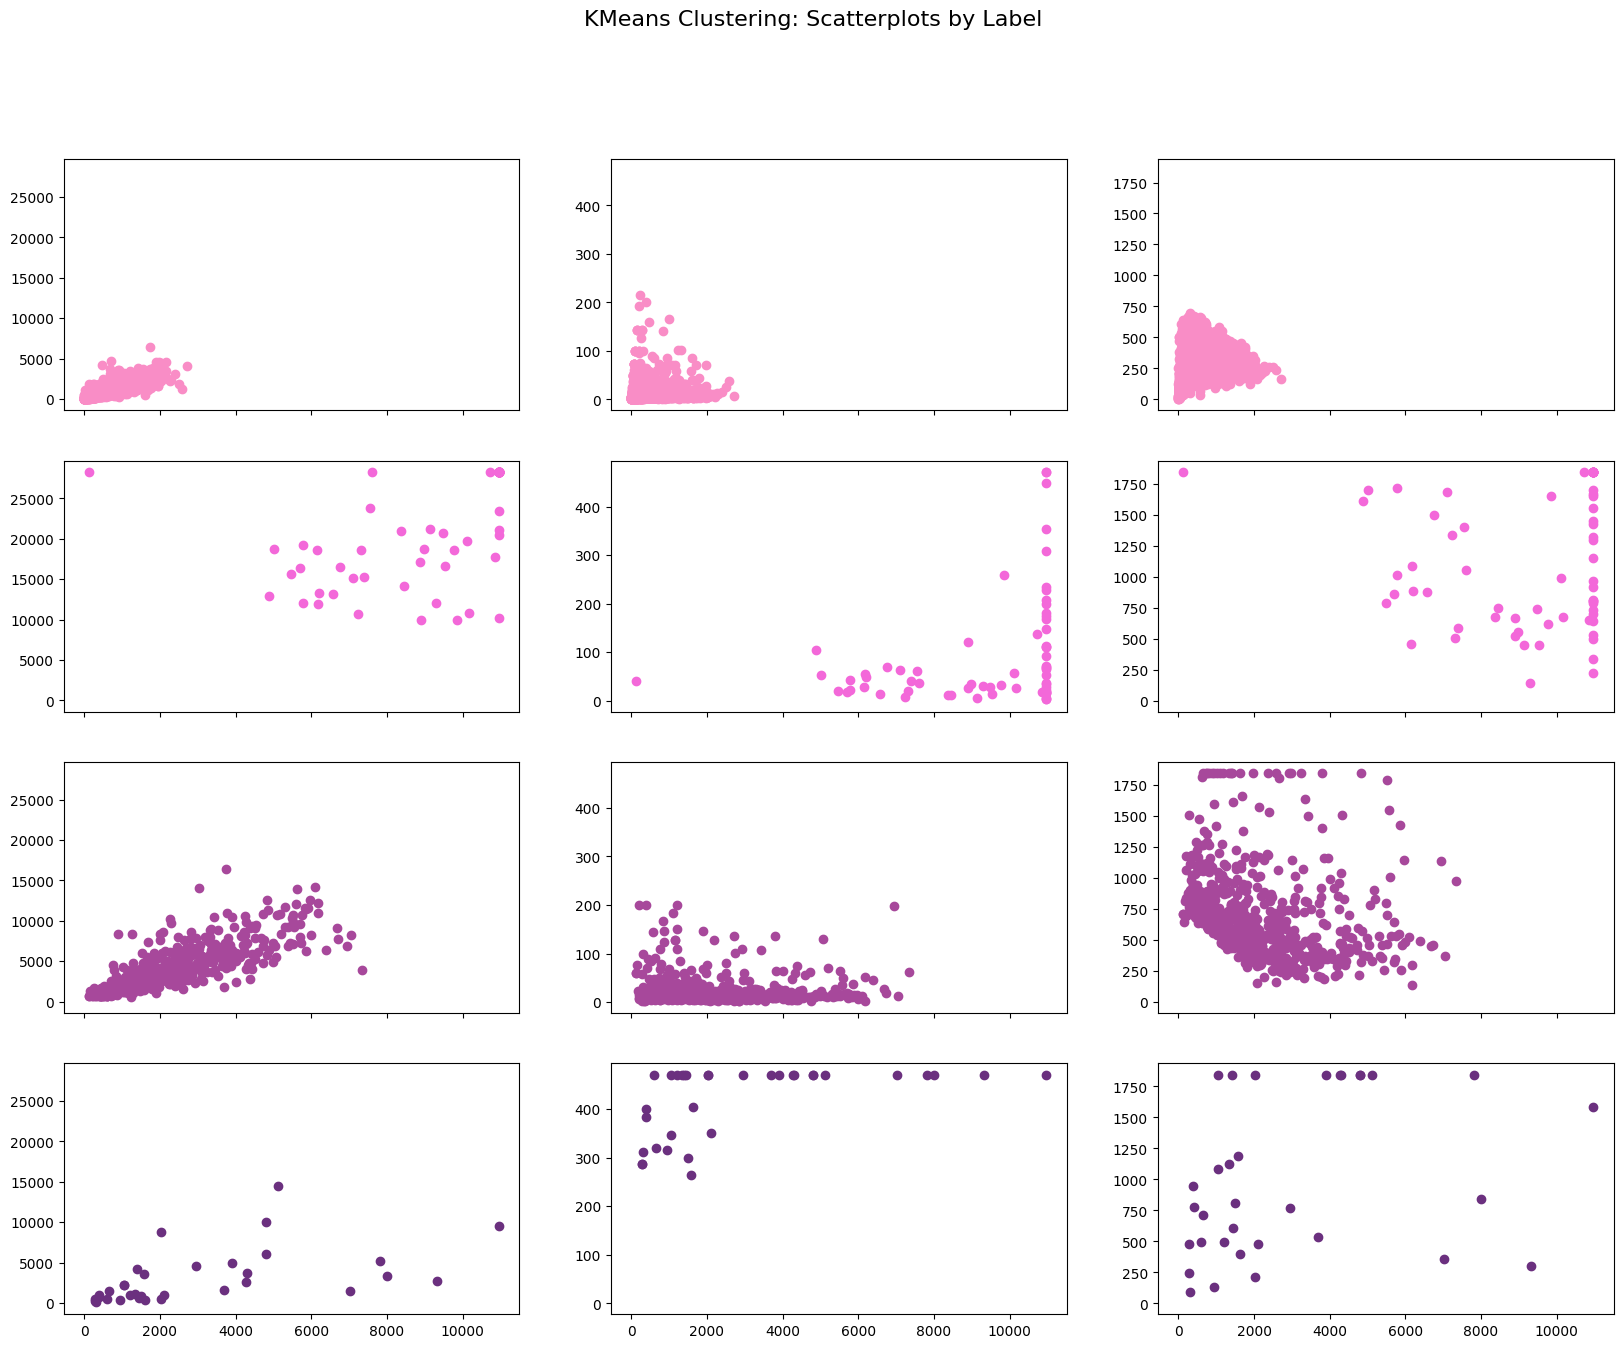

In [80]:
# Making a plots for each label
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,15), sharex='col', sharey='col')
colours = ['#F98DC6', '#F368D9', '#A7489B', '#6B307F']

for i in range(4):
    ax[i,0].scatter(x=cust_clust_kmeans[cust_clust_kmeans.Labels == i].TotalQuantity, y=cust_clust_kmeans[cust_clust_kmeans.Labels == i].TotalValue,c=colours[i])
    ax[i,1].scatter(x=cust_clust_kmeans[cust_clust_kmeans.Labels == i].TotalQuantity, y=cust_clust_kmeans[cust_clust_kmeans.Labels == i].AvrgQuantity,c=colours[i])
    ax[i,2].scatter(x=cust_clust_kmeans[cust_clust_kmeans.Labels == i].TotalQuantity, y=cust_clust_kmeans[cust_clust_kmeans.Labels == i].AvrgOrderValue,c=colours[i])

plt.suptitle("KMeans Clustering: Scatterplots by Label", fontsize=16)
plt.savefig("../images/scatterplotLabelsKmeans.png", bbox_inches='tight')
plt.show()

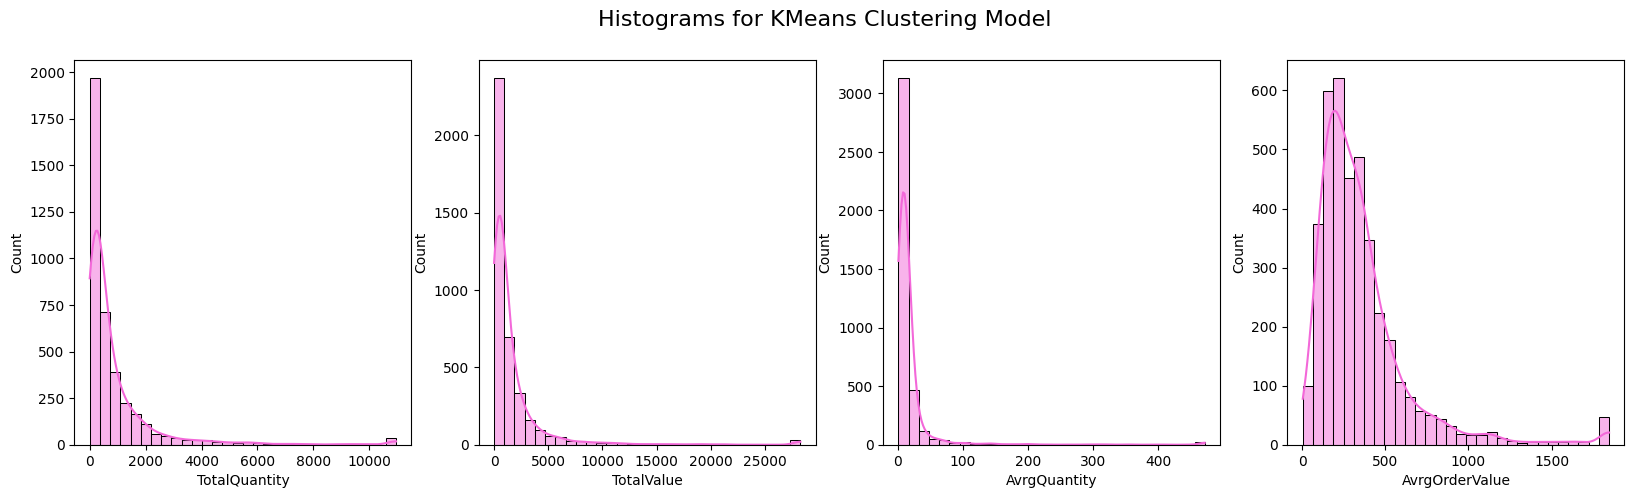

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

sns.histplot(data=cust_clust_kmeans, x='TotalQuantity', kde=True, bins=30, color='#F368D9',ax=ax[0])
sns.histplot(data=cust_clust_kmeans, x='TotalValue', kde=True, bins=30, color='#F368D9', ax=ax[1])
sns.histplot(data=cust_clust_kmeans, x='AvrgQuantity', kde=True, bins=30, color='#F368D9', ax=ax[2])
sns.histplot(data=cust_clust_kmeans, x='AvrgOrderValue', kde=True, bins=30, color='#F368D9', ax=ax[3])

plt.suptitle("Histograms for KMeans Clustering Model", fontsize=16)
plt.savefig("../images/histograms_kmeans.png", bbox_inches='tight')
plt.show()

### Plots for Gaussian Mixture model

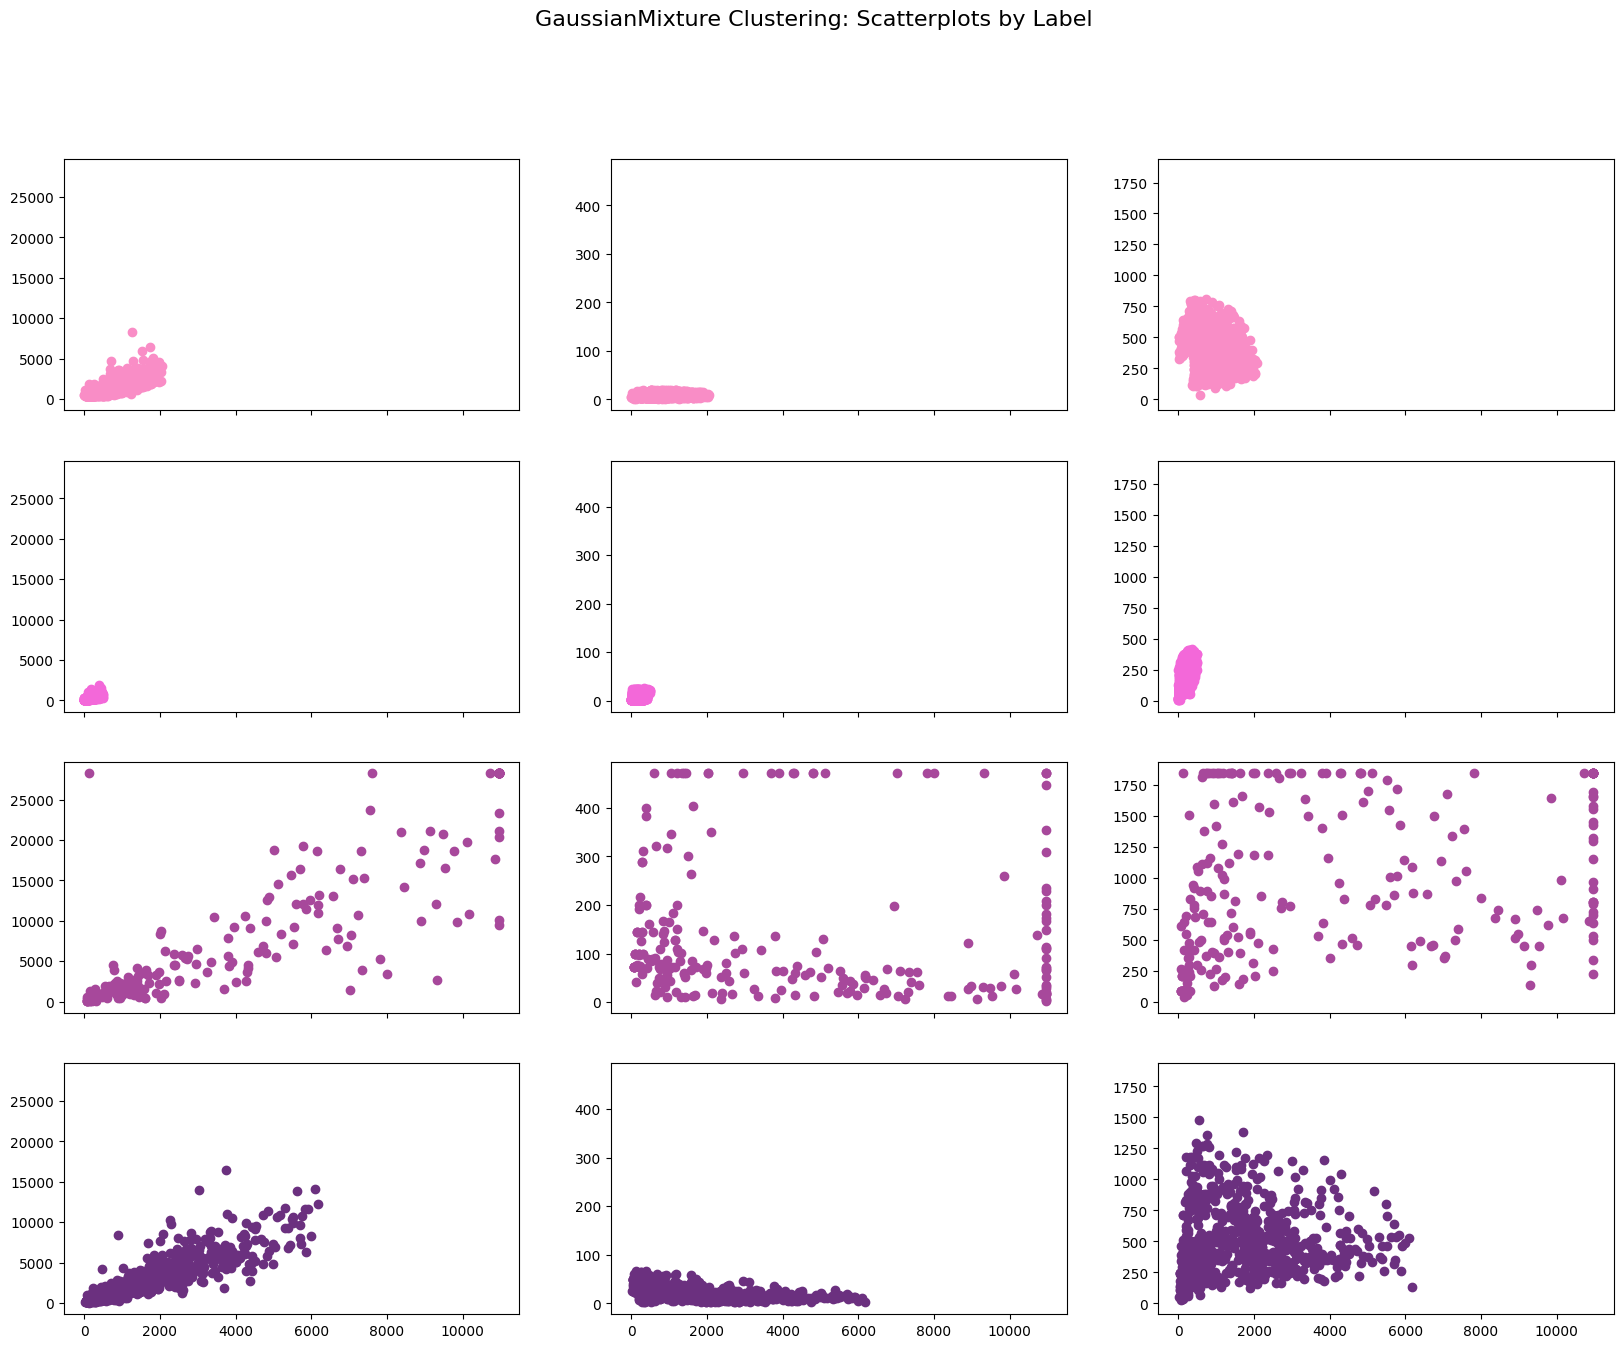

In [81]:
# Making a plots for each label
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,15), sharex='col', sharey='col')
colours = ['#F98DC6', '#F368D9', '#A7489B', '#6B307F']

for i in range(4):
    ax[i,0].scatter(x=cust_clust_gm[cust_clust_gm.Labels == i].TotalQuantity, y=cust_clust_gm[cust_clust_gm.Labels == i].TotalValue,c=colours[i])
    ax[i,1].scatter(x=cust_clust_gm[cust_clust_gm.Labels == i].TotalQuantity, y=cust_clust_gm[cust_clust_gm.Labels == i].AvrgQuantity,c=colours[i])
    ax[i,2].scatter(x=cust_clust_gm[cust_clust_gm.Labels == i].TotalQuantity, y=cust_clust_gm[cust_clust_gm.Labels == i].AvrgOrderValue,c=colours[i])

plt.suptitle("GaussianMixture Clustering: Scatterplots by Label", fontsize=16)
plt.savefig("../images/scatterplotLabelsGM.png", bbox_inches='tight')
plt.show()

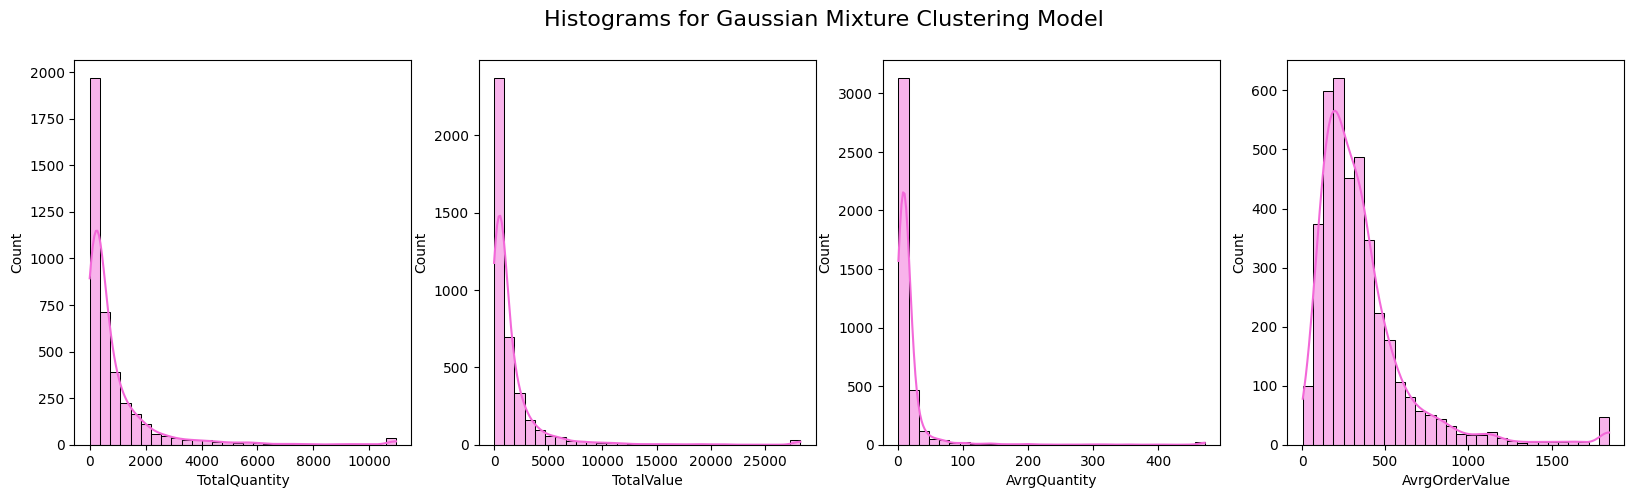

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

sns.histplot(data=cust_clust_gm, x='TotalQuantity', kde=True, bins=30, color='#F368D9',ax=ax[0])
sns.histplot(data=cust_clust_gm, x='TotalValue', kde=True, bins=30, color='#F368D9', ax=ax[1])
sns.histplot(data=cust_clust_gm, x='AvrgQuantity', kde=True, bins=30, color='#F368D9', ax=ax[2])
sns.histplot(data=cust_clust_gm, x='AvrgOrderValue', kde=True, bins=30, color='#F368D9', ax=ax[3])

plt.suptitle("Histograms for Gaussian Mixture Clustering Model", fontsize=16)
plt.savefig("../images/histograms_gm.png", bbox_inches='tight')
plt.show()

### Plots for Mean Shift model

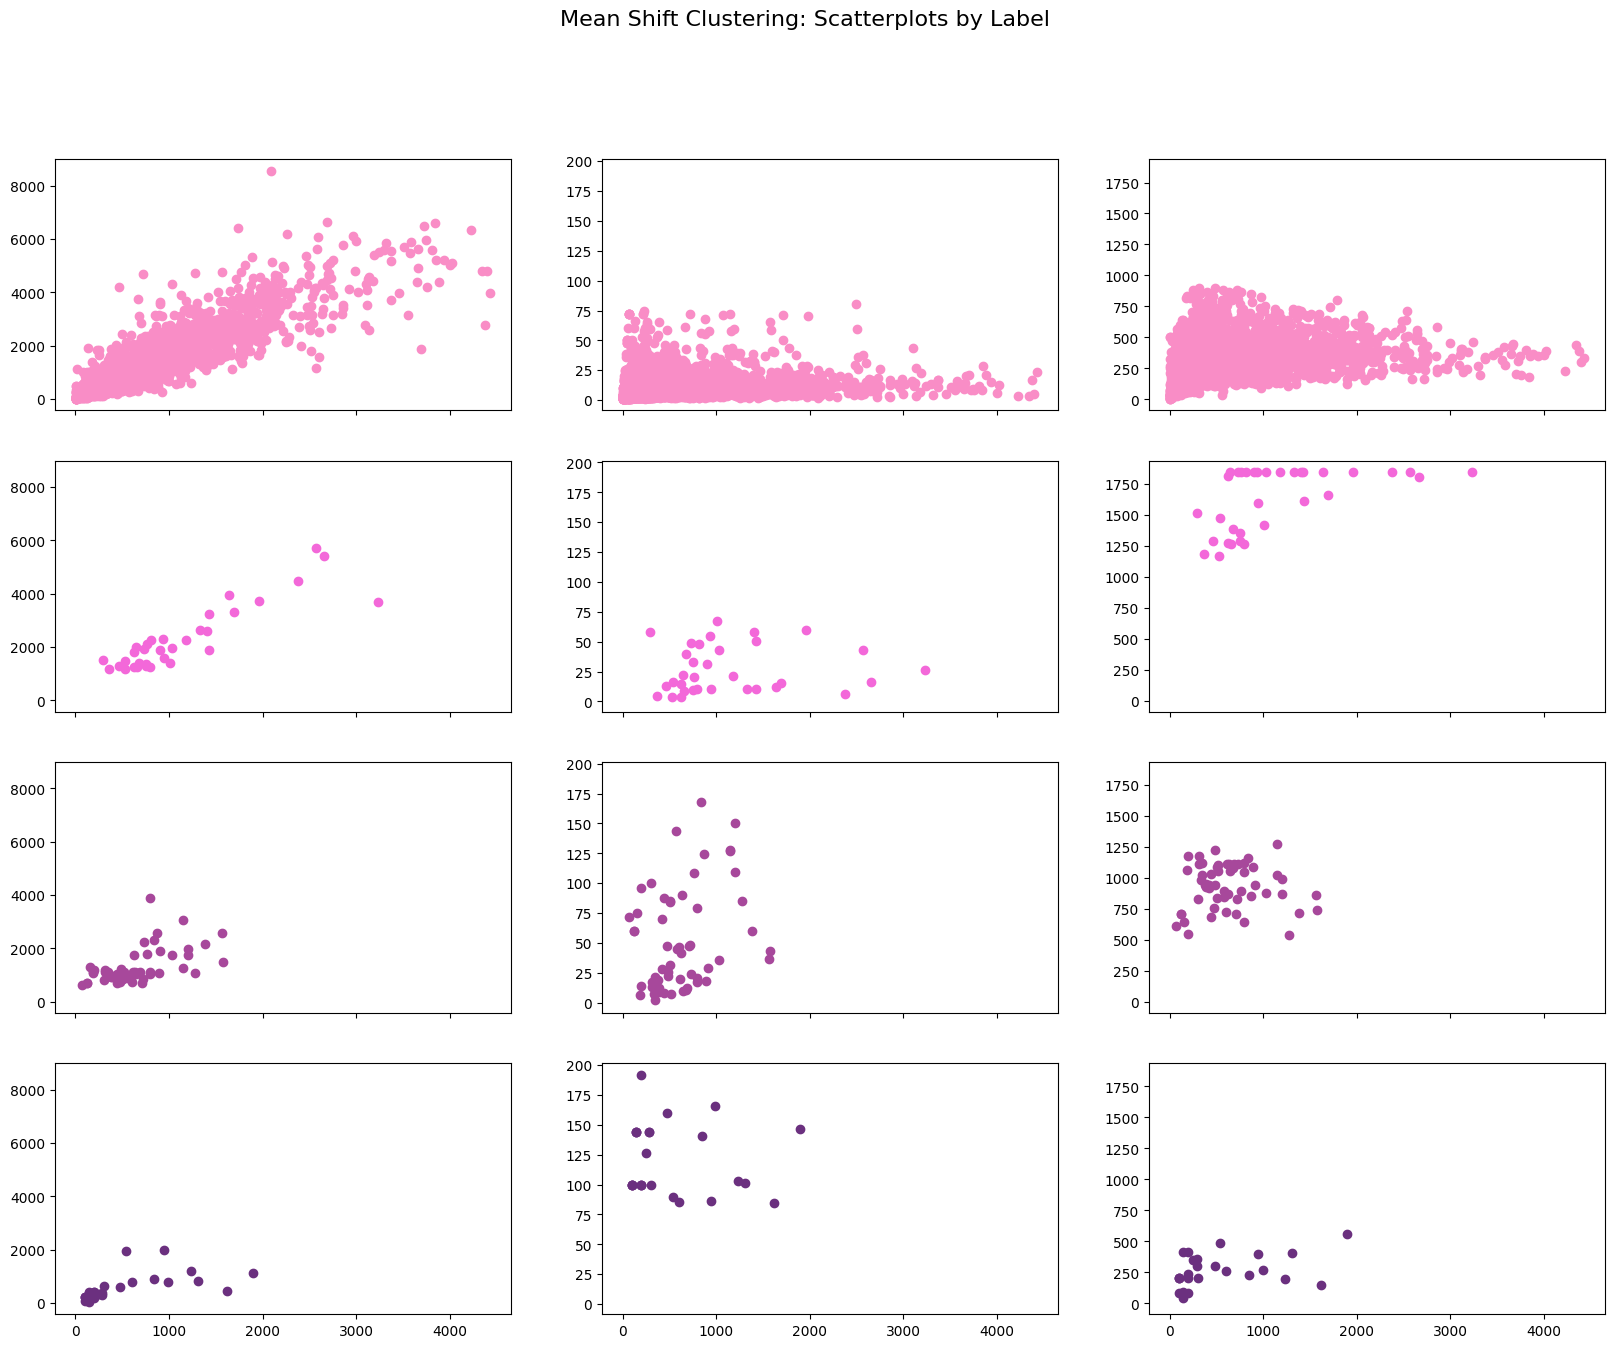

In [83]:
# Making a plots for each label
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,15), sharex='col', sharey='col')
colours = ['#F98DC6', '#F368D9', '#A7489B', '#6B307F']

for i in range(4):
    ax[i,0].scatter(x=cust_clust_mshift[cust_clust_mshift.Labels == i].TotalQuantity, y=cust_clust_mshift[cust_clust_mshift.Labels == i].TotalValue,c=colours[i])
    ax[i,1].scatter(x=cust_clust_mshift[cust_clust_mshift.Labels == i].TotalQuantity, y=cust_clust_mshift[cust_clust_mshift.Labels == i].AvrgQuantity,c=colours[i])
    ax[i,2].scatter(x=cust_clust_mshift[cust_clust_mshift.Labels == i].TotalQuantity, y=cust_clust_mshift[cust_clust_mshift.Labels == i].AvrgOrderValue,c=colours[i])

plt.suptitle("Mean Shift Clustering: Scatterplots by Label", fontsize=16)
plt.savefig("../images/scatterplotLabelsMshiftM.png", bbox_inches='tight')
plt.show()

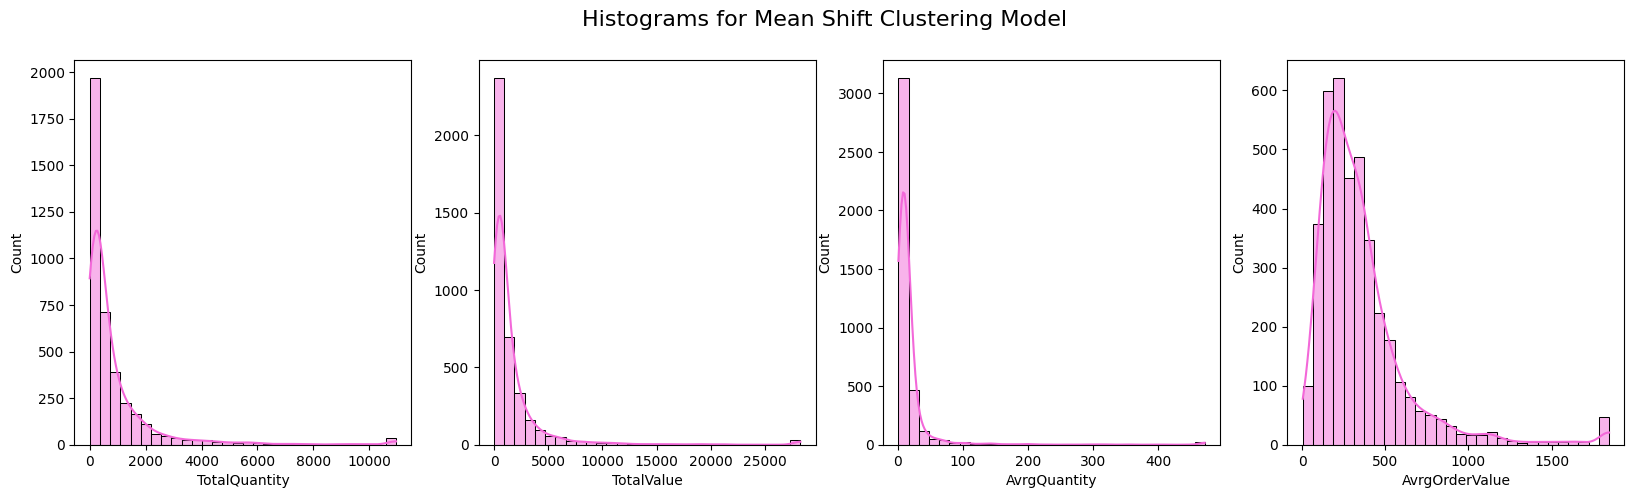

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

sns.histplot(data=cust_clust_mshift, x='TotalQuantity', kde=True, bins=30, color='#F368D9',ax=ax[0])
sns.histplot(data=cust_clust_mshift, x='TotalValue', kde=True, bins=30, color='#F368D9', ax=ax[1])
sns.histplot(data=cust_clust_mshift, x='AvrgQuantity', kde=True, bins=30, color='#F368D9', ax=ax[2])
sns.histplot(data=cust_clust_mshift, x='AvrgOrderValue', kde=True, bins=30, color='#F368D9', ax=ax[3])

plt.suptitle("Histograms for Mean Shift Clustering Model", fontsize=16)
plt.savefig("../images/histograms_mshift.png", bbox_inches='tight')
plt.show()